In [1]:
!pip install DeepMIMO==2

Defaulting to user installation because normal site-packages is not writeable
  Using cached deepmimo-2.0-py3-none-any.whl.metadata (702 bytes)
Using cached deepmimo-2.0-py3-none-any.whl (21 kB)
  Attempting uninstall: DeepMIMO
    Found existing installation: DeepMIMO 3.2.9
    Uninstalling DeepMIMO-3.2.9:
      Successfully uninstalled DeepMIMO-3.2.9


In [2]:
!python --version
!pip show tensorflow

Python 3.11.9
Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/conda/lib/python3.11/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: tf_keras


In [3]:
###### Deep Learning Coordinated Beamforming with DeepMIMO #################
# Author: Umut Demirhan, Ahmed Alkhateeb
# Date: March 19, 2022 
# Paper: A. Alkhateeb, S. Alex, P. Varkey, Y. Li, Q. Qu and D. Tujkovic, 
# "Deep Learning Coordinated Beamforming for Highly-Mobile Millimeter Wave 
# Systems," in IEEE Access, vol. 6, pp. 37328-37348, 2018.
###########################################################################

import DeepMIMO
import os
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from tqdm import tqdm
from scipy.io import loadmat, savemat 
import glob
import re 

plt.rcParams['figure.figsize'] = [12, 8] # Set default plot size



In [4]:
def beamforming_codebook(ant_shape = np.array([1, 32, 1]), oversampling_rate = np.array([1, 1, 1]), kd = 0.5):
    
    kd = 2 * np.pi * kd
    codebook_size = ant_shape * oversampling_rate
    
    vecs = []
    for dim in range(3):
        ind = np.arange(ant_shape[dim]).reshape((-1, 1))
        codebook_ang = np.linspace(0, np.pi, codebook_size[dim], endpoint = False).reshape((1, -1))                                                                                                     
        vec = np.sqrt(1./ant_shape[dim]) * np.exp(-1j * kd * ind * np.cos(codebook_ang))
        vecs.append(vec)
        
    F = np.kron(vecs[2], np.kron(vecs[1], vecs[0]))
    
    return F
    
   

In [25]:
#%% # Generate the dataset
# # Load and print the default parameters
parameters = DeepMIMO.default_params()


# # Change parameters for the setup
# Scenario O1_60 extracted at the dataset_folder
parameters['scenario'] = 'O1_60'
parameters['dataset_folder'] = '' # Set DeepMIMO dataset folder that has O1_60

parameters['num_paths'] = 5

# User rows 1-100
parameters['user_row_first'] = 1000
parameters['user_row_last'] = 1100

# Activate only the first basestation
#parameters['active_BS'] = np.array([3, 4, 5, 6]) 

parameters['active_BS'] = np.array([3]) 


parameters['OFDM']['bandwidth'] = 0.5 # 50 MHz
parameters['OFDM']['subcarriers'] = 1024 # OFDM with 512 subcarriers
parameters['OFDM']['subcarriers_limit'] = 64 # Keep only first 64 subcarriers

parameters['enable_BS2BS'] = False

parameters['ue_antenna']['shape'] = np.array([1, 1, 1]) # Single antenna
parameters['bs_antenna']['shape'] = np.array([1, 32, 8]) # ULA of 32 elements
parameters['bs_antenna']['radiation_pattern'] = 'halfwave-dipole'
parameters['ue_antenna']['radiation_pattern'] = 'halfwave-dipole'
pprint(parameters)

{'OFDM': {'RX_filter': 0,
          'bandwidth': 0.5,
          'subcarriers': 1024,
          'subcarriers_limit': 64,
          'subcarriers_sampling': 1},
 'OFDM_channels': 1,
 'active_BS': array([3]),
 'bs_antenna': {'radiation_pattern': 'halfwave-dipole',
                'shape': array([ 1, 32,  8]),
                'spacing': 0.5},
 'dataset_folder': '',
 'dynamic_settings': {'first_scene': 1, 'last_scene': 1},
 'enable_BS2BS': False,
 'num_paths': 5,
 'row_subsampling': 1,
 'scenario': 'O1_60',
 'ue_antenna': {'radiation_pattern': 'halfwave-dipole',
                'shape': array([1, 1, 1]),
                'spacing': 0.5},
 'user_row_first': 1000,
 'user_row_last': 1100,
 'user_subsampling': 1}


In [26]:
dataset = DeepMIMO.generate_data(parameters)
print(len(dataset))


Basestation 3

UE-BS Channels


Generating channels: 100%|██████████| 18281/18281 [00:06<00:00, 2731.33it/s]

1


In [12]:
len(dataset[0])

3

In [13]:
#%% Parameters and Codebook
F = beamforming_codebook(ant_shape = parameters['bs_antenna'][0]['shape'], oversampling_rate = np.array([1, 2, 1]), kd = parameters['bs_antenna'][0]['spacing'])

num_OFDM = int(parameters['OFDM']['subcarriers_limit']/parameters['OFDM']['subcarriers_sampling'])
num_beams = F.shape[1]
num_bs = len(parameters['active_BS'])
num_ue = len(parameters['active_UE'])



NF = 5             # Noise figure at the base station
Process_Gain = 10  # Channel estimation processing gain
BW = parameters['OFDM']['bandwidth'] * 1e9 # System bandwidth in Hz
noise_power_dB = -204 + 10*np.log10(BW/parameters['OFDM']['subcarriers']) + NF - Process_Gain; # Noise power in dB
noise_power = 10**(.1*(noise_power_dB)); # Noise power

#%% DL Input-Output
input_norm = np.zeros((num_bs, num_ue, num_OFDM), dtype=complex)
max_rates = np.zeros((num_bs, num_ue, num_beams))


In [14]:
#for bs_idx in tqdm(range(num_bs), desc='Neural Network Input-Output Generation-BS', position=0, leave=True):

for bs_idx in tqdm(range(num_bs), desc='Neural Network Input-Output Generation-BS', position=0, leave=True):
    for ue_idx in tqdm(range(num_ue), desc='Neural Network Input-Output Generation-BS-%i'%bs_idx, position=0, leave=True):
        ch = dataset[bs_idx]['user']['channel'][ue_idx].squeeze()
        ch = ch + np.sqrt(noise_power) * (np.random.randn(*(ch.shape)) + 1j * np.random.randn(*(ch.shape)))
        input_norm[bs_idx, ue_idx, :] = ch[0, :]
        max_rates[bs_idx, ue_idx, :] = np.sum(np.log2(1 + np.abs(ch.T.conj() @ F)**2),  axis = 0)/num_OFDM
        

Neural Network Input-Output Generation-BS:   0%|          | 0/1 [01:19<?, ?it/s]


KeyboardInterrupt: 

In [16]:
# Input reshape - normalize
input_norm = np.transpose(input_norm, axes=[1, 0, 2])
input_norm = input_norm.reshape((num_ue, -1))
input_norm /=  np.amax(np.abs(input_norm))

# Output reshape - normalize
max_rates_norm_factor = np.amax(max_rates, axis=2, keepdims=True)
max_rates_norm_factor[max_rates_norm_factor== 0] = 1 # Do not normalize if all zeros
max_rates /= max_rates_norm_factor
max_rates = np.transpose(max_rates, axes=[1, 0, 2])
max_rates = max_rates.reshape((num_ue, -1))

if not os.path.exists('./DLCB_dataset'):
                      os.makedirs('DLCB_dataset')
savemat('./DLCB_dataset/DLCB_input.mat', {'DL_input': input_norm})
savemat('./DLCB_dataset/DLCB_output.mat', {'DL_output': max_rates})


In [17]:
# %% Machine Learning
import os
import keras
import keras.models as models
from keras.layers import Dense,Dropout
import numpy as np

# Model training function
def train(In_train, Out_train, In_test, Out_test,
          epochs, batch_size,dr,
          num_hidden_layers, nodes_per_layer,
          loss_fn,n_BS,n_beams):
    
    in_shp = list(In_train.shape[1:])

    AP_models = []
    for bs_idx in range(n_BS):
        idx_str = 'BS%i' % bs_idx
        idx = bs_idx*n_beams
        
        model = models.Sequential()
        model.add(Dense(nodes_per_layer, activation='relu', kernel_initializer='he_normal', input_shape=in_shp))
        model.add(Dropout(dr))
        for h in range(num_hidden_layers):
            model.add(Dense(nodes_per_layer, activation='relu', kernel_initializer='he_normal'))
            model.add(Dropout(dr))
        
        model.add(Dense(n_beams, activation='relu', kernel_initializer='he_normal',
                  name="dense" + idx_str + "o"))
        model.compile(loss=loss_fn, optimizer='adam')
        model.summary()

        print(Out_train[:, idx:idx + n_beams].shape)
        model.fit(In_train,
                    Out_train[:, idx:idx + n_beams],
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_data=(In_test, Out_test[:,idx:idx + n_beams]),
                    callbacks = [
                        #keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
                        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
                    ])
        
        AP_models.append(model)
        
        
    return AP_models


2025-05-23 07:44:24.069255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747986264.080318   22968 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747986264.083674   22968 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-23 07:44:24.096703: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


0.001


/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1747986266.252950   22968 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10534 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:88:00.0, compute capability: 6.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 512)            │        66,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(14, 512)
Epoch 1/10


I0000 00:00:1747986268.377139   24410 service.cc:148] XLA service 0x7f5b0000ddc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747986268.377164   24410 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-05-23 07:44:28.416334: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747986268.603134   24410 cuda_dnn.cc:529] Loaded cuDNN version 90501


I0000 00:00:1747986269.990522   24410 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 - 4s - 4s/step - loss: 0.0981 - val_loss: 0.0487
Epoch 2/10
1/1 - 0s - 145ms/step - loss: 0.0576 - val_loss: 0.0307
Epoch 3/10
1/1 - 0s - 135ms/step - loss: 0.0316 - val_loss: 0.0207
Epoch 4/10
1/1 - 0s - 145ms/step - loss: 0.0225 - val_loss: 0.0149
Epoch 5/10
1/1 - 0s - 133ms/step - loss: 0.0133 - val_loss: 0.0114
Epoch 6/10
1/1 - 0s - 138ms/step - loss: 0.0097 - val_loss: 0.0092
Epoch 7/10
1/1 - 0s - 136ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 8/10
1/1 - 0s - 127ms/step - loss: 0.0065 - val_loss: 0.0067
Epoch 9/10
1/1 - 0s - 154ms/step - loss: 0.0055 - val_loss: 0.0060
Epoch 10/10
1/1 - 0s - 132ms/step - loss: 0.0047 - val_loss: 0.0054


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 512)            │        66,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(14, 512)
Epoch 1/10
1/1 - 3s - 3s/step - loss: 0.0767 - val_loss: 0.0414
Epoch 2/10
1/1 - 0s - 139ms/step - loss: 0.0450 - val_loss: 0.0260
Epoch 3/10
1/1 - 0s - 132ms/step - loss: 0.0239 - val_loss: 0.0174
Epoch 4/10
1/1 - 0s - 136ms/step - loss: 0.0154 - val_loss: 0.0125
Epoch 5/10
1/1 - 0s - 128ms/step - loss: 0.0111 - val_loss: 0.0096
Epoch 6/10
1/1 - 0s - 139ms/step - loss: 0.0082 - val_loss: 0.0079
Epoch 7/10
1/1 - 0s - 135ms/step - loss: 0.0070 - val_loss: 0.0067
Epoch 8/10
1/1 - 0s - 133ms/step - loss: 0.0053 - val_loss: 0.0059
Epoch 9/10
1/1 - 0s - 150ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 10/10
1/1 - 0s - 125ms/step - loss: 0.0049 - val_loss: 0.0049
0.05


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 512)            │        66,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(731, 512)
Epoch 1/10
8/8 - 5s - 590ms/step - loss: 0.0386 - val_loss: 0.0052
Epoch 2/10
8/8 - 0s - 23ms/step - loss: 0.0051 - val_loss: 0.0033
Epoch 3/10
8/8 - 0s - 19ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/10
8/8 - 0s - 18ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 5/10
8/8 - 0s - 19ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 6/10
8/8 - 0s - 17ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 7/10
8/8 - 0s - 20ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 8/10
8/8 - 0s - 18ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 9/10
8/8 - 0s - 19ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 10/10
8/8 - 0s - 18ms/step - loss: 0.0029 - val_loss: 0.0028


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 512)            │        66,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(731, 512)
Epoch 1/10
8/8 - 4s - 548ms/step - loss: 0.0282 - val_loss: 0.0044
Epoch 2/10
8/8 - 0s - 17ms/step - loss: 0.0043 - val_loss: 0.0031
Epoch 3/10
8/8 - 0s - 18ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 4/10
8/8 - 0s - 19ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 5/10
8/8 - 0s - 18ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 6/10
8/8 - 0s - 18ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 7/10
8/8 - 0s - 19ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 8/10
8/8 - 0s - 16ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 9/10
8/8 - 0s - 18ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 10/10
8/8 - 0s - 18ms/step - loss: 0.0026 - val_loss: 0.0027
0.1


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 512)            │        66,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(1462, 512)
Epoch 1/10
15/15 - 5s - 306ms/step - loss: 0.0171 - val_loss: 0.0033
Epoch 2/10
15/15 - 0s - 11ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 3/10
15/15 - 0s - 11ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 4/10
15/15 - 0s - 11ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 5/10
15/15 - 0s - 10ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 6/10
15/15 - 0s - 20ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 7/10
15/15 - 0s - 12ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 8/10
15/15 - 0s - 9ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 9/10
15/15 - 0s - 10ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 10/10
15/15 - 0s - 10ms/step - loss: 0.0027 - val_loss: 0.0027


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 512)            │        66,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(1462, 512)
Epoch 1/10
15/15 - 5s - 309ms/step - loss: 0.0235 - val_loss: 0.0033
Epoch 2/10
15/15 - 0s - 12ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 3/10
15/15 - 0s - 10ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 4/10
15/15 - 0s - 11ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 5/10
15/15 - 0s - 12ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 6/10
15/15 - 0s - 10ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 7/10
15/15 - 0s - 11ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 8/10
15/15 - 0s - 10ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 9/10
15/15 - 0s - 11ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 10/10
15/15 - 0s - 10ms/step - loss: 0.0026 - val_loss: 0.0026
0.15


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 512)            │        66,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(2193, 512)
Epoch 1/10
22/22 - 5s - 209ms/step - loss: 0.0198 - val_loss: 0.0032
Epoch 2/10
22/22 - 0s - 8ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 3/10
22/22 - 0s - 8ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 4/10
22/22 - 0s - 8ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 5/10
22/22 - 0s - 7ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 6/10
22/22 - 0s - 8ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 7/10
22/22 - 0s - 8ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 8/10
22/22 - 0s - 7ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 9/10
22/22 - 0s - 7ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 10/10
22/22 - 0s - 8ms/step - loss: 0.0027 - val_loss: 0.0027


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 512)            │        66,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(2193, 512)
Epoch 1/10
22/22 - 4s - 201ms/step - loss: 0.0127 - val_loss: 0.0029
Epoch 2/10
22/22 - 0s - 8ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 3/10
22/22 - 0s - 7ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 4/10
22/22 - 0s - 8ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 5/10
22/22 - 0s - 8ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 6/10
22/22 - 0s - 7ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 7/10
22/22 - 0s - 8ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 8/10
22/22 - 0s - 8ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 9/10
22/22 - 0s - 8ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 10/10
22/22 - 0s - 7ms/step - loss: 0.0025 - val_loss: 0.0025
0.2


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 512)            │        66,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(2924, 512)
Epoch 1/10
30/30 - 5s - 156ms/step - loss: 0.0122 - val_loss: 0.0030
Epoch 2/10
30/30 - 0s - 6ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 3/10
30/30 - 0s - 6ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 4/10
30/30 - 0s - 6ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 5/10
30/30 - 0s - 6ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 6/10
30/30 - 0s - 6ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 7/10
30/30 - 0s - 6ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 8/10
30/30 - 0s - 6ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 9/10
30/30 - 0s - 6ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 10/10
30/30 - 0s - 6ms/step - loss: 0.0026 - val_loss: 0.0025


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 512)            │        66,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(2924, 512)
Epoch 1/10
30/30 - 5s - 152ms/step - loss: 0.0107 - val_loss: 0.0028
Epoch 2/10
30/30 - 0s - 6ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 3/10
30/30 - 0s - 6ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 4/10
30/30 - 0s - 6ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 5/10
30/30 - 0s - 6ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 6/10
30/30 - 0s - 6ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 7/10
30/30 - 0s - 6ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 8/10
30/30 - 0s - 6ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 9/10
30/30 - 0s - 6ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 10/10
30/30 - 0s - 6ms/step - loss: 0.0025 - val_loss: 0.0024
0.25


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_50 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 512)            │        66,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(3656, 512)
Epoch 1/10
37/37 - 5s - 133ms/step - loss: 0.0101 - val_loss: 0.0029
Epoch 2/10
37/37 - 0s - 5ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 3/10
37/37 - 0s - 6ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 4/10
37/37 - 0s - 5ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 5/10
37/37 - 0s - 5ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 6/10
37/37 - 0s - 5ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 7/10
37/37 - 0s - 5ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 8/10
37/37 - 0s - 5ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 9/10
37/37 - 0s - 5ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 10/10
37/37 - 0s - 5ms/step - loss: 0.0024 - val_loss: 0.0023


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_55 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 512)            │        66,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(3656, 512)
Epoch 1/10
37/37 - 5s - 125ms/step - loss: 0.0103 - val_loss: 0.0028
Epoch 2/10
37/37 - 0s - 5ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 3/10
37/37 - 0s - 5ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 4/10
37/37 - 0s - 5ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 5/10
37/37 - 0s - 5ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 6/10
37/37 - 0s - 5ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 7/10
37/37 - 0s - 5ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 8/10
37/37 - 0s - 5ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 9/10
37/37 - 0s - 5ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 10/10
37/37 - 0s - 5ms/step - loss: 0.0024 - val_loss: 0.0024
0.3


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 512)            │        66,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(4387, 512)
Epoch 1/10
44/44 - 5s - 108ms/step - loss: 0.0117 - val_loss: 0.0030
Epoch 2/10
44/44 - 0s - 5ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 3/10
44/44 - 0s - 5ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 4/10
44/44 - 0s - 5ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 5/10
44/44 - 0s - 4ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 6/10
44/44 - 0s - 4ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 7/10
44/44 - 0s - 5ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 8/10
44/44 - 0s - 5ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 9/10
44/44 - 0s - 5ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 10/10
44/44 - 0s - 5ms/step - loss: 0.0026 - val_loss: 0.0025


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_65 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 512)            │        66,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(4387, 512)
Epoch 1/10
44/44 - 4s - 101ms/step - loss: 0.0057 - val_loss: 0.0027
Epoch 2/10
44/44 - 0s - 5ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 3/10
44/44 - 0s - 5ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 4/10
44/44 - 0s - 5ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 5/10
44/44 - 0s - 5ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 6/10
44/44 - 0s - 5ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 7/10
44/44 - 0s - 4ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 8/10
44/44 - 0s - 4ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 9/10
44/44 - 0s - 5ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 10/10
44/44 - 0s - 4ms/step - loss: 0.0019 - val_loss: 0.0018
0.35


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_70 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 512)            │        66,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(5118, 512)
Epoch 1/10
52/52 - 5s - 91ms/step - loss: 0.0078 - val_loss: 0.0028
Epoch 2/10
52/52 - 0s - 4ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 3/10
52/52 - 0s - 4ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 4/10
52/52 - 0s - 4ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 5/10
52/52 - 0s - 4ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 6/10
52/52 - 0s - 4ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 7/10
52/52 - 0s - 4ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 8/10
52/52 - 0s - 5ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 9/10
52/52 - 0s - 4ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 10/10
52/52 - 0s - 4ms/step - loss: 0.0021 - val_loss: 0.0019


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_75 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 512)            │        66,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(5118, 512)
Epoch 1/10
52/52 - 5s - 88ms/step - loss: 0.0079 - val_loss: 0.0027
Epoch 2/10
52/52 - 0s - 4ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 3/10
52/52 - 0s - 4ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 4/10
52/52 - 0s - 4ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 5/10
52/52 - 0s - 4ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 6/10
52/52 - 0s - 4ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 7/10
52/52 - 0s - 4ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 8/10
52/52 - 0s - 4ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 9/10
52/52 - 0s - 4ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 10/10
52/52 - 0s - 4ms/step - loss: 0.0020 - val_loss: 0.0019
0.4


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_80 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 512)            │        66,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(5849, 512)
Epoch 1/10
59/59 - 5s - 86ms/step - loss: 0.0076 - val_loss: 0.0028
Epoch 2/10
59/59 - 0s - 4ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 3/10
59/59 - 0s - 4ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 4/10
59/59 - 0s - 4ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 5/10
59/59 - 0s - 4ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 6/10
59/59 - 0s - 4ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 7/10
59/59 - 0s - 4ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 8/10
59/59 - 0s - 4ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 9/10
59/59 - 0s - 4ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 10/10
59/59 - 0s - 4ms/step - loss: 0.0020 - val_loss: 0.0018


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_85 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 512)            │        66,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(5849, 512)
Epoch 1/10
59/59 - 5s - 77ms/step - loss: 0.0079 - val_loss: 0.0027
Epoch 2/10
59/59 - 0s - 4ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 3/10
59/59 - 0s - 4ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 4/10
59/59 - 0s - 4ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 5/10
59/59 - 0s - 4ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 6/10
59/59 - 0s - 5ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 7/10
59/59 - 0s - 4ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 8/10
59/59 - 0s - 4ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 9/10
59/59 - 0s - 4ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 10/10
59/59 - 0s - 4ms/step - loss: 0.0019 - val_loss: 0.0018
0.45


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_90 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_92 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_93 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_94 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 512)            │        66,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(6580, 512)
Epoch 1/10
66/66 - 5s - 71ms/step - loss: 0.0061 - val_loss: 0.0028
Epoch 2/10
66/66 - 0s - 3ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 3/10
66/66 - 0s - 4ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 4/10
66/66 - 0s - 3ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 5/10
66/66 - 0s - 3ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 6/10
66/66 - 0s - 4ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 7/10
66/66 - 0s - 4ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 8/10
66/66 - 0s - 4ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 9/10
66/66 - 0s - 4ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 10/10
66/66 - 0s - 3ms/step - loss: 0.0018 - val_loss: 0.0016


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_95 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_99 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 512)            │        66,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(6580, 512)
Epoch 1/10
66/66 - 5s - 70ms/step - loss: 0.0073 - val_loss: 0.0027
Epoch 2/10
66/66 - 0s - 4ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 3/10
66/66 - 0s - 3ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 4/10
66/66 - 0s - 3ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 5/10
66/66 - 0s - 4ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 6/10
66/66 - 0s - 3ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 7/10
66/66 - 0s - 3ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 8/10
66/66 - 0s - 3ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 9/10
66/66 - 0s - 4ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 10/10
66/66 - 0s - 4ms/step - loss: 0.0018 - val_loss: 0.0017
0.5


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_100 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_101 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_102 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_103 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_104 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 512)            │        66,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(7312, 512)
Epoch 1/10
74/74 - 5s - 65ms/step - loss: 0.0074 - val_loss: 0.0028
Epoch 2/10
74/74 - 0s - 4ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 3/10
74/74 - 0s - 3ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 4/10
74/74 - 0s - 3ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 5/10
74/74 - 0s - 4ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 6/10
74/74 - 0s - 3ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 7/10
74/74 - 0s - 3ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 8/10
74/74 - 0s - 3ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 9/10
74/74 - 0s - 3ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 10/10
74/74 - 0s - 3ms/step - loss: 0.0021 - val_loss: 0.0019


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_105 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_105 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_106 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_107 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_109 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 512)            │        66,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(7312, 512)
Epoch 1/10
74/74 - 5s - 63ms/step - loss: 0.0077 - val_loss: 0.0027
Epoch 2/10
74/74 - 0s - 3ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 3/10
74/74 - 0s - 3ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 4/10
74/74 - 0s - 4ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 5/10
74/74 - 0s - 3ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 6/10
74/74 - 0s - 3ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 7/10
74/74 - 0s - 3ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 8/10
74/74 - 0s - 3ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 9/10
74/74 - 0s - 3ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 10/10
74/74 - 0s - 3ms/step - loss: 0.0017 - val_loss: 0.0015
0.55


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_110 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_112 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 512)            │        66,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(8043, 512)
Epoch 1/10
81/81 - 5s - 60ms/step - loss: 0.0061 - val_loss: 0.0028
Epoch 2/10
81/81 - 0s - 3ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 3/10
81/81 - 0s - 3ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 4/10
81/81 - 0s - 3ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 5/10
81/81 - 0s - 4ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 6/10
81/81 - 0s - 3ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 7/10
81/81 - 0s - 3ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 8/10
81/81 - 0s - 3ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 9/10
81/81 - 0s - 3ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 10/10
81/81 - 0s - 3ms/step - loss: 0.0017 - val_loss: 0.0014


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_115 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_115 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_116 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_117 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_118 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_119 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 512)            │        66,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(8043, 512)
Epoch 1/10
81/81 - 5s - 61ms/step - loss: 0.0060 - val_loss: 0.0027
Epoch 2/10
81/81 - 0s - 3ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 3/10
81/81 - 0s - 3ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 4/10
81/81 - 0s - 3ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 5/10
81/81 - 0s - 3ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 6/10
81/81 - 0s - 3ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 7/10
81/81 - 0s - 3ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 8/10
81/81 - 0s - 4ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 9/10
81/81 - 0s - 3ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 10/10
81/81 - 0s - 3ms/step - loss: 0.0016 - val_loss: 0.0015
0.6


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_120 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_120 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_121 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_122 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_123 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_124 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 512)            │        66,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(8774, 512)
Epoch 1/10
88/88 - 5s - 53ms/step - loss: 0.0064 - val_loss: 0.0028
Epoch 2/10
88/88 - 0s - 3ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 3/10
88/88 - 0s - 3ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 4/10
88/88 - 0s - 3ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 5/10
88/88 - 0s - 3ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 6/10
88/88 - 0s - 3ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 7/10
88/88 - 0s - 3ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 8/10
88/88 - 0s - 3ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 9/10
88/88 - 0s - 3ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 10/10
88/88 - 0s - 3ms/step - loss: 0.0016 - val_loss: 0.0013


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_125 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_125 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_126 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_126 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_127 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_127 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_128 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_129 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_129 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 512)            │        66,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(8774, 512)
Epoch 1/10
88/88 - 5s - 53ms/step - loss: 0.0050 - val_loss: 0.0026
Epoch 2/10
88/88 - 0s - 3ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 3/10
88/88 - 0s - 3ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 4/10
88/88 - 0s - 3ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 5/10
88/88 - 0s - 3ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 6/10
88/88 - 0s - 3ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 7/10
88/88 - 0s - 3ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 8/10
88/88 - 0s - 3ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 9/10
88/88 - 0s - 3ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 10/10
88/88 - 0s - 4ms/step - loss: 0.0014 - val_loss: 0.0012
0.65


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_130 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_130 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_131 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_132 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_133 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_134 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 512)            │        66,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(9505, 512)
Epoch 1/10
96/96 - 5s - 49ms/step - loss: 0.0057 - val_loss: 0.0027
Epoch 2/10
96/96 - 0s - 3ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 3/10
96/96 - 0s - 3ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 4/10
96/96 - 0s - 3ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 5/10
96/96 - 0s - 3ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 6/10
96/96 - 0s - 3ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 7/10
96/96 - 0s - 3ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 8/10
96/96 - 0s - 3ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 9/10
96/96 - 0s - 3ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 10/10
96/96 - 0s - 3ms/step - loss: 0.0015 - val_loss: 0.0012


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_135 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_135 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_136 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_137 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_138 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_139 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 512)            │        66,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(9505, 512)
Epoch 1/10
96/96 - 5s - 49ms/step - loss: 0.0078 - val_loss: 0.0026
Epoch 2/10
96/96 - 0s - 3ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 3/10
96/96 - 0s - 3ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 4/10
96/96 - 0s - 3ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 5/10
96/96 - 0s - 3ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 6/10
96/96 - 0s - 3ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 7/10
96/96 - 0s - 3ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 8/10
96/96 - 0s - 3ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 9/10
96/96 - 0s - 3ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 10/10
96/96 - 0s - 3ms/step - loss: 0.0016 - val_loss: 0.0014
0.7


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_140 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_140 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_141 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_142 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_143 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_144 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 512)            │        66,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(10236, 512)
Epoch 1/10
103/103 - 5s - 47ms/step - loss: 0.0050 - val_loss: 0.0027
Epoch 2/10
103/103 - 0s - 3ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 3/10
103/103 - 0s - 3ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 4/10
103/103 - 0s - 3ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 5/10
103/103 - 0s - 3ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 6/10
103/103 - 0s - 3ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 7/10
103/103 - 0s - 3ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 8/10
103/103 - 0s - 3ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 9/10
103/103 - 0s - 3ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 10/10
103/103 - 0s - 3ms/step - loss: 0.0014 - val_loss: 0.0011


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_145 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_145 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_146 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_147 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_147 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_148 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_149 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 512)            │        66,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(10236, 512)
Epoch 1/10
103/103 - 5s - 45ms/step - loss: 0.0047 - val_loss: 0.0026
Epoch 2/10
103/103 - 0s - 3ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 3/10
103/103 - 0s - 3ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 4/10
103/103 - 0s - 3ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 5/10
103/103 - 0s - 3ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 6/10
103/103 - 0s - 3ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 7/10
103/103 - 0s - 3ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 8/10
103/103 - 0s - 3ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 9/10
103/103 - 0s - 3ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 10/10
103/103 - 0s - 3ms/step - loss: 0.0013 - val_loss: 0.0011


Calculating results: 100%|██████████| 15/15 [00:40<00:00,  2.70s/it]


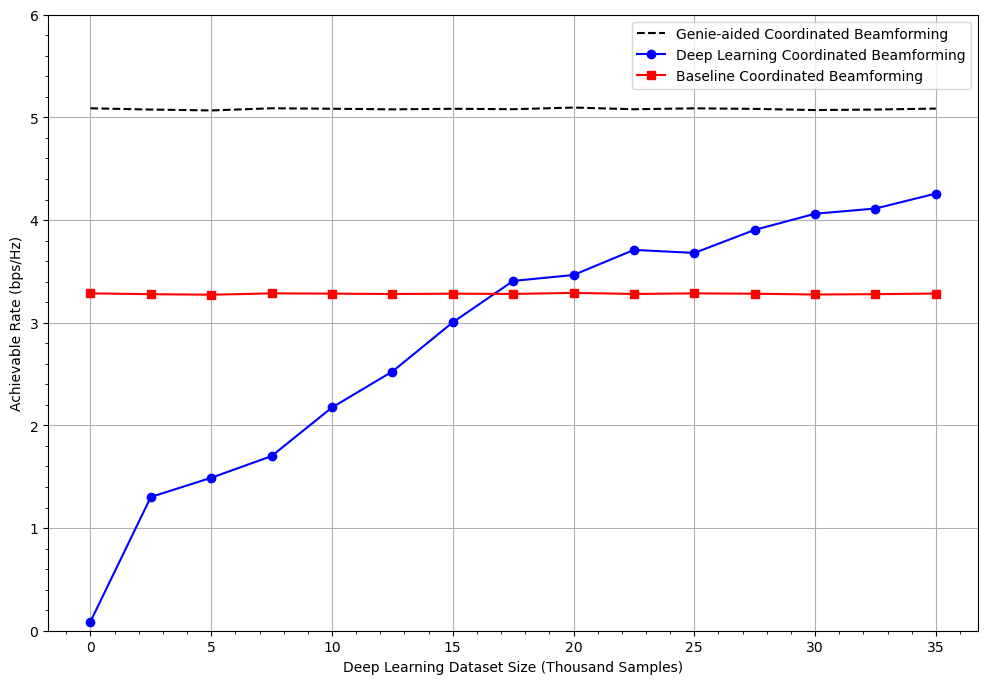

In [18]:
# Reading input and output sets generated from MATLAB
In_set_file=loadmat('DLCB_dataset/DLCB_input.mat')
Out_set_file=loadmat('DLCB_dataset/DLCB_output.mat')

In_set=In_set_file['DL_input']
Out_set=Out_set_file['DL_output']

# Parameter initialization
num_user_tot=In_set.shape[0]
n_DL_size=[0.001, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7]
count=0
num_tot_TX=2
num_beams=512

for DL_size_ratio in n_DL_size:
    
    print (DL_size_ratio)
    count=count+1
    DL_size=int(num_user_tot*DL_size_ratio)
    
    np.random.seed(2016)
    n_examples = DL_size
    num_train  = int(DL_size * 0.8)
    num_test   = int(num_user_tot*.2)
    
    train_index = np.random.choice(range(0,num_user_tot), size=num_train, replace=False)
    rem_index = set(range(0,num_user_tot))-set(train_index)
    test_index= list(set(np.random.choice(list(rem_index), size=num_test, replace=False)))
    
    In_train = In_set[train_index]
    In_test =  In_set[test_index] 
        
    Out_train = Out_set[train_index]
    Out_test = Out_set[test_index]
    
    
    # Learning model parameters
    epochs = 10     
    batch_size = 100  
    dr = 0.05                  # dropout rate  
    num_hidden_layers=4
    nodes_per_layer=In_train.shape[1]
    loss_fn='mean_squared_error'
    
    # Model training
    AP_models = train(In_train, Out_train, In_test, Out_test,
                                          epochs, batch_size,dr,
                                          num_hidden_layers, nodes_per_layer,
                                          loss_fn,num_tot_TX,num_beams)

    
    # Model running/testing
    DL_Result={}
    for idx in range(0,num_tot_TX,1): 
        beams_predicted=AP_models[idx].predict( In_test, batch_size=10, verbose=0)
    
        DL_Result['TX'+str(idx+1)+'Pred_Beams']=beams_predicted
        DL_Result['TX'+str(idx+1)+'Opt_Beams']=Out_test[:,idx*num_beams:(idx+1)*num_beams]

    DL_Result['user_index']=test_index
    
    
    if not os.path.exists('./DLCB_code_output'):
                          os.makedirs('DLCB_code_output')
    savemat('DLCB_code_output/DL_Result'+str(count)+'.mat',DL_Result)

#%% Read Results
file_list = sorted(glob.glob('DLCB_code_output/DL_Result*'), key=lambda x: int(re.findall(r'\d+', x)[0]))
num_files = len(file_list)

user_index = []
pred_beams = []
opt_beams = []
for file in tqdm(file_list, desc='Reading DL results'):
    matfile = loadmat(file)
    l1 = []
    l2 = []
    for idx in range(num_bs):
        l1.append(matfile['TX'+str(idx+1)+'Pred_Beams'])
        l2.append(matfile['TX'+str(idx+1)+'Opt_Beams'])
        
    pred_beams.append(l1)
    opt_beams.append(l2)
    user_index.append(matfile['user_index'])


Pn = -204 + 10*np.log10(BW) # Noise power in dB
SNR = 10**(.1*(0-Pn))

ach_rate_DL = np.zeros(num_files)
ach_rate_opt = np.zeros(num_files)

eff_rate = np.zeros(num_files)
opt_rate = np.zeros(num_files)
for file_idx in tqdm(np.arange(num_files), desc = 'Calculating results'):
    user_index_file = user_index[file_idx].flatten()
    for ue_idx in range(len(user_index_file)):
        eff_ch = []
        opt_ch = []
        for bs_idx in range(num_bs):
            if file_idx == 0: # Random BF - 0 Samples
                pred_beam_idx = np.random.randint(num_beams)
            else:
                pred_beam_idx = np.argmax(pred_beams[file_idx][bs_idx][ue_idx])
            opt_beam_idx = np.argmax(opt_beams[file_idx][bs_idx][ue_idx])
            ch_single_bs = dataset[bs_idx]['user']['channel'][user_index_file[ue_idx]].squeeze()
            eff_ch_single_pred = ch_single_bs.T.conj() @ F[:, pred_beam_idx]
            opt_ch_single_pred = ch_single_bs.T.conj() @ F[:, opt_beam_idx]
            eff_ch.append(eff_ch_single_pred)
            opt_ch.append(opt_ch_single_pred)
        eff_ch = np.array(eff_ch)
        opt_ch = np.array(opt_ch)
        eff_rate[file_idx] += np.sum(np.log2(1 + SNR * np.abs(np.diag(eff_ch.conj().T @ eff_ch))))
        opt_rate[file_idx] += np.sum(np.log2(1 + SNR * np.abs(np.diag(opt_ch.conj().T @ opt_ch))))
    eff_rate[file_idx] /= len(user_index_file)*num_OFDM
    opt_rate[file_idx] /= len(user_index_file)*num_OFDM


# % Eff achievable rate calculations
theta_user=(102/parameters['bs_antenna'][0]['shape'][1])*np.pi/180
alpha=60*np.pi/180
distance_user=10
Tc_const=(distance_user*theta_user)/(2*np.sin(alpha)) # ms
Tt=10*1e-6; # ms

v_mph=50
v=v_mph*1000*1.6/3600 # m/s
Tc=Tc_const/v

overhead_opt=1-(num_beams*Tt)/Tc # overhead of beam training
overhead_DL=1-Tt/Tc # overhead of proposed DL method

#%% Plotting the figure
DL_size_array=np.arange(0, 2.5*(num_files), 2.5);

fig, ax = plt.subplots()
plt.plot(DL_size_array, opt_rate, '--k', label = 'Genie-aided Coordinated Beamforming')
plt.plot(DL_size_array, eff_rate*overhead_DL, '-bo', label = 'Deep Learning Coordinated Beamforming')
plt.plot(DL_size_array, opt_rate*overhead_opt, '-rs', label = 'Baseline Coordinated Beamforming')
plt.ylim([0, 6])
plt.minorticks_on()
plt.grid()
plt.xlabel('Deep Learning Dataset Size (Thousand Samples)')
plt.ylabel('Achievable Rate (bps/Hz)')
plt.legend()
plt.savefig('result.png')
